In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind

# Description of the dataset

**Source of dataset:** https://www.kaggle.com/datasets/zynicide/wine-reviews

**Number of observations**

**Number of variables per observation**



In [2]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
90449,90449,US,Exuberant green apple and quince aromas meet a...,SP Reserve Brut,90,45.0,Virginia,Monticello,NaN,Alexander Peartree,NaN,Trump 2008 SP Reserve Brut Sparkling (Monticello),Sparkling Blend,Trump
66628,66628,Portugal,This light wine has vanilla flavors from wood ...,Aluzé,86,26.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta do Pessegueiro 2010 Aluzé Red (Douro),Portuguese Red,Quinta do Pessegueiro
128183,128183,Australia,This medium-bodied Chardonnay is a bit tart an...,NaN,86,21.0,South Australia,Eden Valley,NaN,Joe Czerwinski,@JoeCz,Hill-Smith Estate 2014 Chardonnay (Eden Valley),Chardonnay,Hill-Smith Estate
7735,7735,US,Light aromas of red cherry and cranberry meet ...,NaN,88,25.0,California,Santa Lucia Highlands,Central Coast,Matt Kettmann,@mattkettmann,Sextant 2014 Pinot Noir (Santa Lucia Highlands),Pinot Noir,Sextant
72107,72107,Italy,Here's a light and fragrant Sangiovese from Mo...,NaN,86,13.0,Southern Italy,Terra degli Osci,NaN,NaN,NaN,Borgo di Colloredo 2006 Sangiovese (Terra degl...,Sangiovese,Borgo di Colloredo


**Meaning and type of the different variables**

In [3]:
df.dtypes

Unnamed: 0                 int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

# Data Cleaning

The column ‘Unnamed: 0’ is not needed as it is the line number and we already have that.

We find that the columns ‘taster_name’ and ‘taster_twitter_handle’ are also not useful for our project.

We proceed to delete these columns from the dataframe:

In [4]:
df.drop(columns=['Unnamed: 0', 'taster_name', 'taster_twitter_handle'], inplace=True)

## Drop duplicates

as first we check for duplicates and delete them

In [5]:
duplicated = df.duplicated().sum()
print(f"Total duplicate: {duplicated}")
df.drop_duplicates(inplace=True)
duplicated = df.duplicated().sum()
print(f"Total duplicate: {duplicated}")

Total duplicate: 9983
Total duplicate: 0


## Data Quality Assessment

Display of missing values, unique values and duplicates of each column

In [6]:
# Initialize a list to store the data
data_quality = []

# Calculate the metrics for each column and store them in the list
for column in df.columns:
    nan_count = df[column].isna().sum()
    unique_count = df[column].nunique()
    total_entries = df.shape[0]
    duplicates = total_entries - unique_count - nan_count
    
    data_quality.append({
        'Column': column,
        'Missing Values': nan_count,
        'Unique Values': unique_count,
        'Duplicates': duplicates
    })

# Create a DataFrame from the list
data_quality_df = pd.DataFrame(data_quality)

data_quality_df

,Column,Missing Values,Unique Values,Duplicates
0,country,59,43,119886
1,description,0,119955,33
2,designation,34545,37979,47464
3,points,0,21,119967
4,price,8395,390,111203
5,province,59,425,119504
6,region_1,19560,1229,99199
7,region_2,73219,17,46752
8,title,0,118840,1148
9,variety,1,707,119280


the columns that need to be arranged are ‘country’, ‘designation’, ‘price’, ‘province’, 'region_1', “region_2” and “variety”.

I also have to check ‘description’ as it should be unique for each wine

## Country column analysis

Filtering the DataFrame to show only rows where 'country' has NaN values

In [7]:
# Filter the DataFrame to show only rows where 'country' has NaN values
rows_with_nan = df[df['country'].isna()]
rows_with_nan.head(10)

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
913,NaN,"Amber in color, this wine has aromas of peach ...",Asureti Valley,87,30.0,NaN,NaN,NaN,Gotsa Family Wines 2014 Asureti Valley Chinuri,Chinuri,Gotsa Family Wines
3131,NaN,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,NaN,NaN,NaN,Barton & Guestier NV Partager Red,Red Blend,Barton & Guestier
4243,NaN,"Violet-red in color, this semisweet wine has a...",Red Naturally Semi-Sweet,88,18.0,NaN,NaN,NaN,Kakhetia Traditional Winemaking 2012 Red Natur...,Ojaleshi,Kakhetia Traditional Winemaking
9509,NaN,This mouthwatering blend starts with a nose of...,Theopetra Malagouzia-Assyrtiko,92,28.0,NaN,NaN,NaN,Tsililis 2015 Theopetra Malagouzia-Assyrtiko W...,White Blend,Tsililis
9750,NaN,This orange-style wine has a cloudy yellow-gol...,Orange Nikolaevo Vineyard,89,28.0,NaN,NaN,NaN,Ross-idi 2015 Orange Nikolaevo Vineyard Chardo...,Chardonnay,Ross-idi
11150,NaN,"A blend of 85% Melnik, 10% Grenache Noir and 5...",NaN,89,20.0,NaN,NaN,NaN,Orbelus 2013 Melnik,Melnik,Orbelus
11348,NaN,"Light and fruity, this is a wine that has some...",Partager,82,NaN,NaN,NaN,NaN,Barton & Guestier NV Partager White,White Blend,Barton & Guestier
14030,NaN,"This Furmint, grown in marl soils, has aromas ...",Márga,88,25.0,NaN,NaN,NaN,St. Donat 2013 Márga White,White Blend,St. Donat
16000,NaN,"Jumpy, jammy aromas of foxy black fruits are s...",Valle de los Manantiales Vineyard,86,40.0,NaN,NaN,NaN,Familia Deicas 2015 Valle de los Manantiales V...,Tannat,Familia Deicas
16749,NaN,Winemaker: Bartho Eksteen. This wooded Sauvy s...,Cape Winemakers Guild Vloekskoot Wooded,91,NaN,NaN,NaN,NaN,Bartho Eksteen 2016 Cape Winemakers Guild Vloe...,Sauvignon Blanc,Bartho Eksteen


**59** lines are missing the *country*, *province* and *region*, so we have no idea where the wine comes from.

As these are 59 lines out of 111538, we decide to delete them.

In [8]:
df = df.dropna(subset=["country"])

## Description column analysis

Above we can see that the column "description" has 33 duplicate, a description is something unique, we must investigate

now i will display some duplicate wine to understand better 

In [9]:
# Check for duplicates in the 'description' column
duplicate_descriptions = df[df.duplicated(subset='description', keep=False)]

# Display the duplicate 
#duplicate_descriptions_full = duplicate_descriptions
#duplicate_descriptions_full

duplicate_example = duplicate_descriptions[duplicate_descriptions['description'] == duplicate_descriptions.iloc[0]['description']]
duplicate_example_full = duplicate_example.head(5)

duplicate_example_full


,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
2159,Italy,"Easygoing and enjoyable, this has aromas of ma...",NaN,84,15.0,Central Italy,Montepulciano d'Abruzzo,NaN,Valori 2014 Montepulciano d'Abruzzo,Montepulciano,Valori
22963,Italy,"Easygoing and enjoyable, this has aromas of ma...",NaN,86,NaN,Central Italy,Montepulciano d'Abruzzo,NaN,Quattro Mani 2015 Montepulciano d'Abruzzo,Montepulciano,Quattro Mani


in this case we can see that all columns have the same values.

we show several rows to see if this is the case for all duplicates

In [10]:
sorted_duplicates = duplicate_descriptions.sort_values(by='description')
sorted_duplicates

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
71853,France,90–92. Barrel sample. This is a solid and dens...,Barrel Sample,91,NaN,Bordeaux,Moulis-en-Médoc,NaN,Château Maucaillou 2012 Barrel Sample (Moulis...,Bordeaux-style Red Blend,Château Maucaillou
71851,France,90–92. Barrel sample. This is a solid and dens...,Barrel Sample,91,NaN,Bordeaux,Margaux,NaN,Château Pontac-Lynch 2012 Barrel Sample (Marg...,Bordeaux-style Red Blend,Château Pontac-Lynch
105559,France,92–94. Barrel sample. With so much spicy fruit...,Barrel Sample,93,NaN,Bordeaux,Saint-Julien,NaN,Château Gruaud Larose 2012 Barrel Sample (Sai...,Bordeaux-style Red Blend,Château Gruaud Larose
105554,France,92–94. Barrel sample. With so much spicy fruit...,Barrel Sample,93,NaN,Bordeaux,Pauillac,NaN,Château Grand-Puy-Lacoste 2012 Barrel Sample ...,Bordeaux-style Red Blend,Château Grand-Puy-Lacoste
73905,Italy,"Almost too much of a good thing, Passo is a th...",Passo,88,35.0,Veneto,Rosso del Veronese,NaN,Stefano Accordini 2007 Passo Red (Rosso del Ve...,Red Blend,Stefano Accordini
...,...,...,...,...,...,...,...,...,...,...,...
19269,Italy,This zesty red has pretty aromas that suggest ...,NaN,87,30.0,Tuscany,Rosso di Montalcino,NaN,Carpineto 2014 Rosso di Montalcino,Sangiovese,Carpineto
83693,US,Very ripe and forward in baked fruit or pie-fi...,NaN,84,45.0,California,Santa Ynez Valley,Central Coast,Sunstone 2006 Syrah (Santa Ynez Valley),Syrah,Sunstone
61484,US,Very ripe and forward in baked fruit or pie-fi...,Reserve,85,48.0,California,Santa Ynez Valley,Central Coast,Sunstone 2006 Reserve Syrah (Santa Ynez Valley),Syrah,Sunstone
31584,Italy,"Vibrant and spicy, this savory red delivers ar...",Costera,90,18.0,Sicily & Sardinia,Cannonau di Sardegna,NaN,Argiolas 2013 Costera (Cannonau di Sardegna),Red Blend,Argiolas


You can see that in these wines, although the description is the same, there are columns with different values, so they are not duplicates

## Handle NaN

### Columns with string data type

In [11]:
rows_with_nan = df[df['variety'].isna()]
rows_with_nan

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
86909,Chile,"A chalky, dusty mouthfeel nicely balances this...",NaN,88,17.0,Maipo Valley,NaN,NaN,Carmen 1999 (Maipo Valley),NaN,Carmen


In [12]:
df['variety'].fillna('Not-Available', inplace=True)

In [13]:
# Define the columns you want to check and replace NaN values
columns_to_check = ['designation', 'province', 'region_1', 'region_2', 'variety']

# Iterate over each column and replace NaN values with 'Not-available'
for column in columns_to_check:
    # Find the index of the row with NaN in the current column
    row_with_nan_index = df[df[column].isna()].index

    # Assign 'Not-available' to that row and column
    df.loc[row_with_nan_index, column] = 'Not-available'

### Price column

It makes no sense to replace NaN in the price with 0, because in most statistics we would discard these rows.
So we decide to delete these 8391 rows

In [14]:
nan_count = df['price'].isna().sum()
print("Before:")
print(f"total NaN in price: {nan_count}")

#df['price'] = df['price'].fillna(0).astype('float64')
df = df.dropna(subset=['price'])

nan_count = df['price'].isna().sum()
print("After:")
print(f"total NaN in price: {nan_count}")

Before:
total NaN in price: 8391
After:
total NaN in price: 0


## Noises

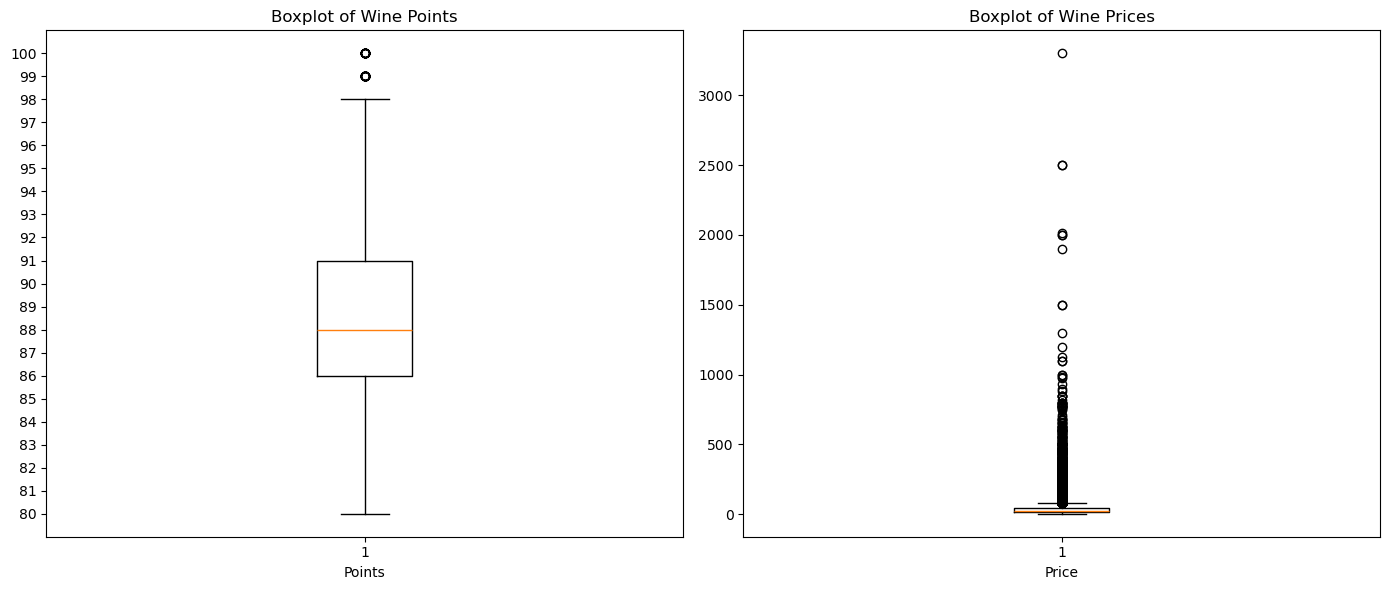

In [47]:
# Create boxplots for 'points' and 'price'
plt.figure(figsize=(14, 6))

# Boxplot for 'points'
plt.subplot(1, 2, 1)
plt.boxplot(df['points'])
plt.title('Boxplot of Wine Points')
plt.xlabel('Points')
plt.yticks(np.arange(80, 101, 1))

# Boxplot for 'price'
plt.subplot(1, 2, 2)
plt.boxplot(df['price'])
plt.title('Boxplot of Wine Prices')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

From the boxplot of the points, we can see that we only have two Vaudores as noise,

The price boxplot doesn't tell us much in this visualisation, so let's plot it horizontally.

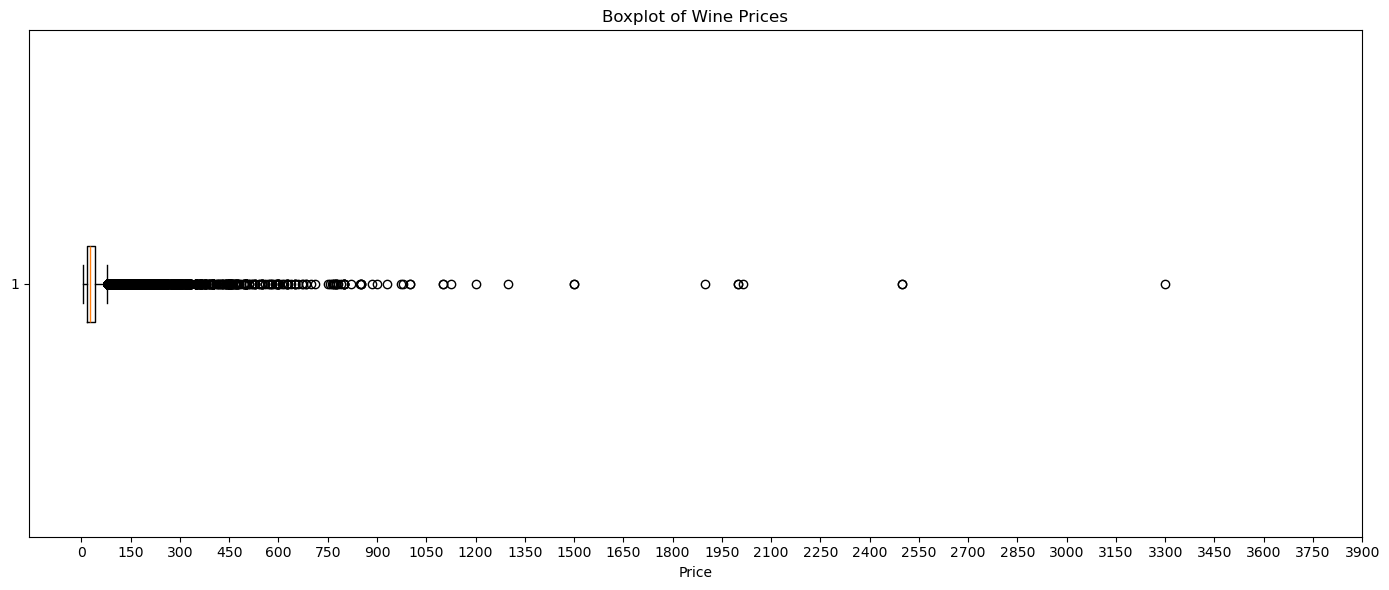

In [42]:
# Create boxplots for 'points' and 'price'
plt.figure(figsize=(14, 6))

# Boxplot for 'price'
#plt.subplot(1, 2, 2)
plt.boxplot(df['price'], vert=False)
plt.title('Boxplot of Wine Prices')
plt.xlabel('Price')
plt.xticks(np.arange(0, 4000, 150))

plt.tight_layout()
plt.show()

# Preprocessing

with this dataset is interesting create new columns, like price category and wine vintage

## Price Category column


at first we plot the histogram of the price to have a global idea

c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


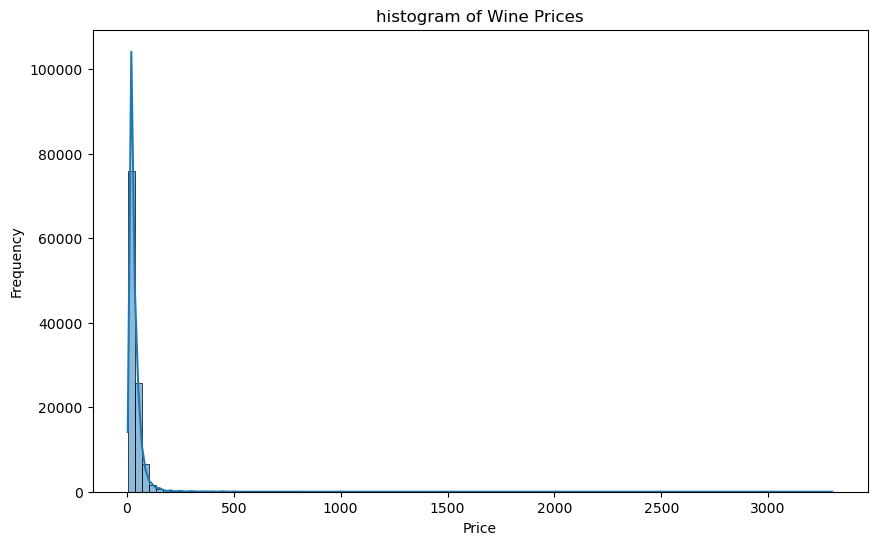

In [15]:
# Create a filtered DataFrame excluding rows where 'price' is 0 for the histogram
df_non_zero_price = df[df['price'] > 0]

plt.figure(figsize=(10, 6))
sns.histplot(df_non_zero_price['price'], bins=100, kde=True)
plt.title('histogram of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

0.33      20.0
0.66      35.0
1.00    3300.0
Name: price, dtype: float64
Low Price Range: 4.0 to 20.0
Medium Price Range: 20.0 to 35.0
High Price Range: 35.0 to 3300.0
   price price_category
1   15.0            Low
2   14.0            Low
3   13.0            Low
4   65.0           High
5   15.0            Low


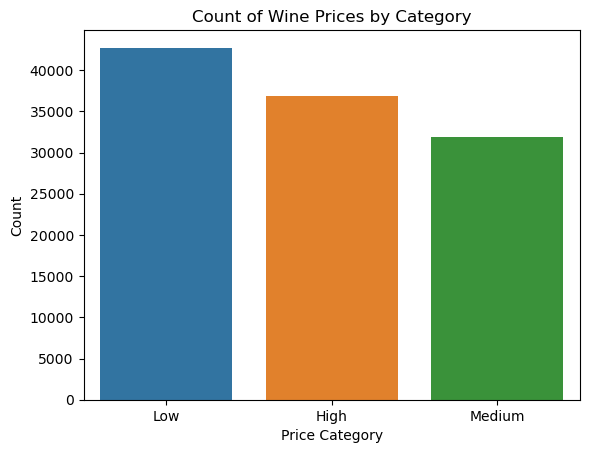

In [16]:

# Calculate quantiles
price_percentiles = df_non_zero_price['price'].quantile([0.33, 0.66, 1.0])
print(price_percentiles)

# Print the bounds for each category
low_bound = (df_non_zero_price['price'].min(), price_percentiles[0.33])
medium_bound = (price_percentiles[0.33], price_percentiles[0.66])
high_bound = (price_percentiles[0.66], df_non_zero_price['price'].max())

print(f"Low Price Range: {low_bound[0]} to {low_bound[1]}")
print(f"Medium Price Range: {medium_bound[0]} to {medium_bound[1]}")
print(f"High Price Range: {high_bound[0]} to {high_bound[1]}")

# Define categories based on the percentiles
def categorize_price(price):
    if price <= price_percentiles[0.33]:
        return 'Low'
    elif price <= price_percentiles[0.66]:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create a new column
df_non_zero_price['price_category'] = df_non_zero_price['price'].apply(categorize_price)

# Check the new column
print(df_non_zero_price[['price', 'price_category']].head())

# Visualize the categorized data
sns.countplot(data=df_non_zero_price, x='price_category')
plt.title('Count of Wine Prices by Category')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.show()

## Wine Vintage column

In [17]:
import re
# Function to extract the vintage year from the title or description
def extract_vintage(row):
    # Try to find the year in the title first
    title_match = re.search(r'\b(19|20)\d{2}\b', row['title'])
    if title_match:
        return int(title_match.group(0))
    # If not found in title, try to find the year in the description
    description_match = re.search(r'\b(19|20)\d{2}\b', row['description'])
    if description_match:
        return int(description_match.group(0))
    # If not found in either, return None
    return None

# Apply the function to the dataframe to create the vintage column
df['vintage'] = df.apply(extract_vintage, axis=1)

nan_counts = df.isna().sum()
nan_counts
print("Number of NaN: ", nan_count)

# Converting the vintage column to integer type to remove the .0
df['vintage'] = df['vintage'].astype('Int64')

#new column check
df[['title', 'description', 'vintage']].head()


Number of NaN:  0


,title,description,vintage
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",2011
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",2013
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",2013
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",2012
5,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Blackberry and raspberry aromas show a typical...,2011


In [18]:
df

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,vintage
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Not-available,Not-available,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",Not-available,87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Not-available,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Not-available,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011
...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,Not-available,Not-available,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2013
129967,US,Citation is given as much as a decade of bottl...,Not-available,90,75.0,Oregon,Oregon,Oregon Other,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,2004
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,Not-available,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013
129969,France,"A dry style of Pinot Gris, this is crisp with ...",Not-available,90,32.0,Alsace,Alsace,Not-available,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2012


# Data Exploration

 Analysis and visualisation of our data 

c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


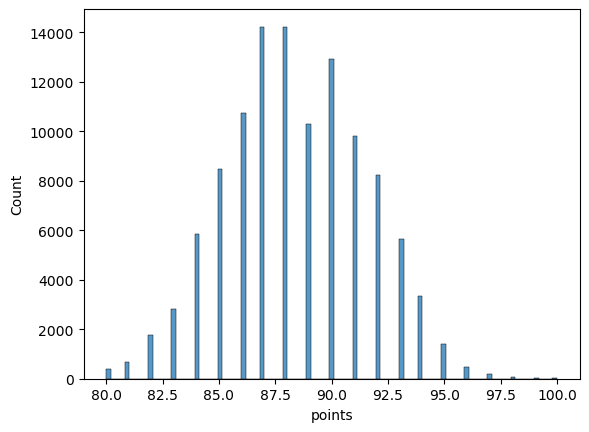

c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


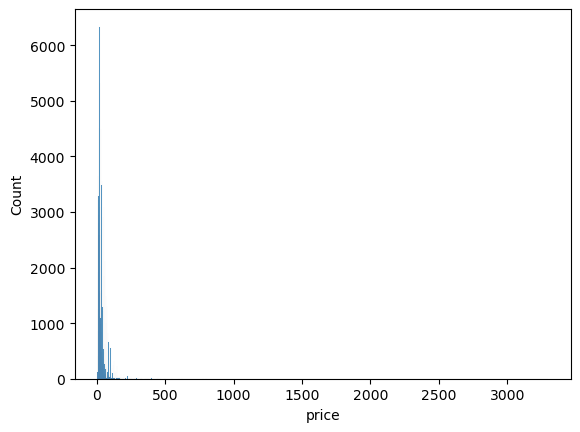

TypeError: boolean value of NA is ambiguous

In [19]:
for i in df.select_dtypes(include="number").columns:
    sns.histplot(data=df, x=i)
    plt.show()

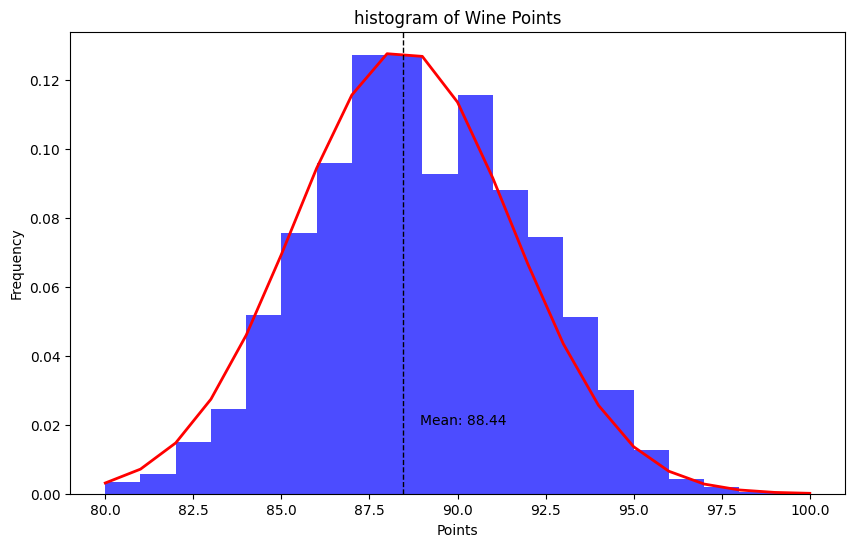

In [ ]:
# Histogram of Wine Points
# Assuming 'points' is your column of interest
mean_points = df['points'].mean()
std_points = df['points'].std()

# Generate values for the normal distribution curve
normal_dist = stats.norm.pdf(sorted(df['points']), mean_points, std_points)

plt.figure(figsize=(10, 6))
plt.hist(df['points'], bins=20, density=True, color='blue', alpha=0.7)
plt.plot(sorted(df['points']), normal_dist, color='red', linewidth=2)
plt.title('histogram of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.axvline(mean_points, color='k', linestyle='dashed', linewidth=1)
plt.text(mean_points + 0.5, 0.02, f'Mean: {mean_points:.2f}', rotation=0)
plt.show()



In [ ]:
import plotly.express as px
# Ensure the country data is clean
df['country'] = df['country'].fillna('Unknown')

# Count the number of wines per country
country_wine_counts = df['country'].value_counts().reset_index()
country_wine_counts.columns = ['country', 'count']

# Generate the world map
fig = px.choropleth(country_wine_counts,
                    locations="country",
                    locationmode='country names',
                    color="count",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="World Wine Distribution")
fig.update_layout(width=1200, height=600)
fig.show()

# Hypotesis testing

## state of three hypotesis testing:
1 - Null Hypothesis (H0): There is no difference in the average price of red wines and white wines.
    Alternative Hypothesis (H1): There is a significant difference in the average price of red wines compared to white wines.

2 - Null Hypothesis (H0): The mean rating of wines from 2000 onwards is equal to or less than the mean rating of wines produced before 2000.
    Alternative Hypothesis (H1): The mean rating of wines from 2000 onwards is higher than the mean rating of wines produced before 2000.

3 - Null hypothesis (H0): There is no difference in average points between wines from Italy and France.
    Alternative hypothesis (H1): There is a difference in average points between wines from Italy and France. 

In [ ]:
# 3
italy_points = df[df['country'] == 'Italy']['points']
france_points = df[df['country'] == 'France']['points']

# Perform t-test
t_stat, p_value = ttest_ind(italy_points.dropna(), france_points.dropna())
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -9.733349596129866, P-value: 2.3069295011679336e-22


# Confidence Intervals

### Wine Ratings Confidence Intervals By Country

95% Confidence Interval for the Mean Points of Wines: (88.39561673460544, 88.43199358654071)


c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


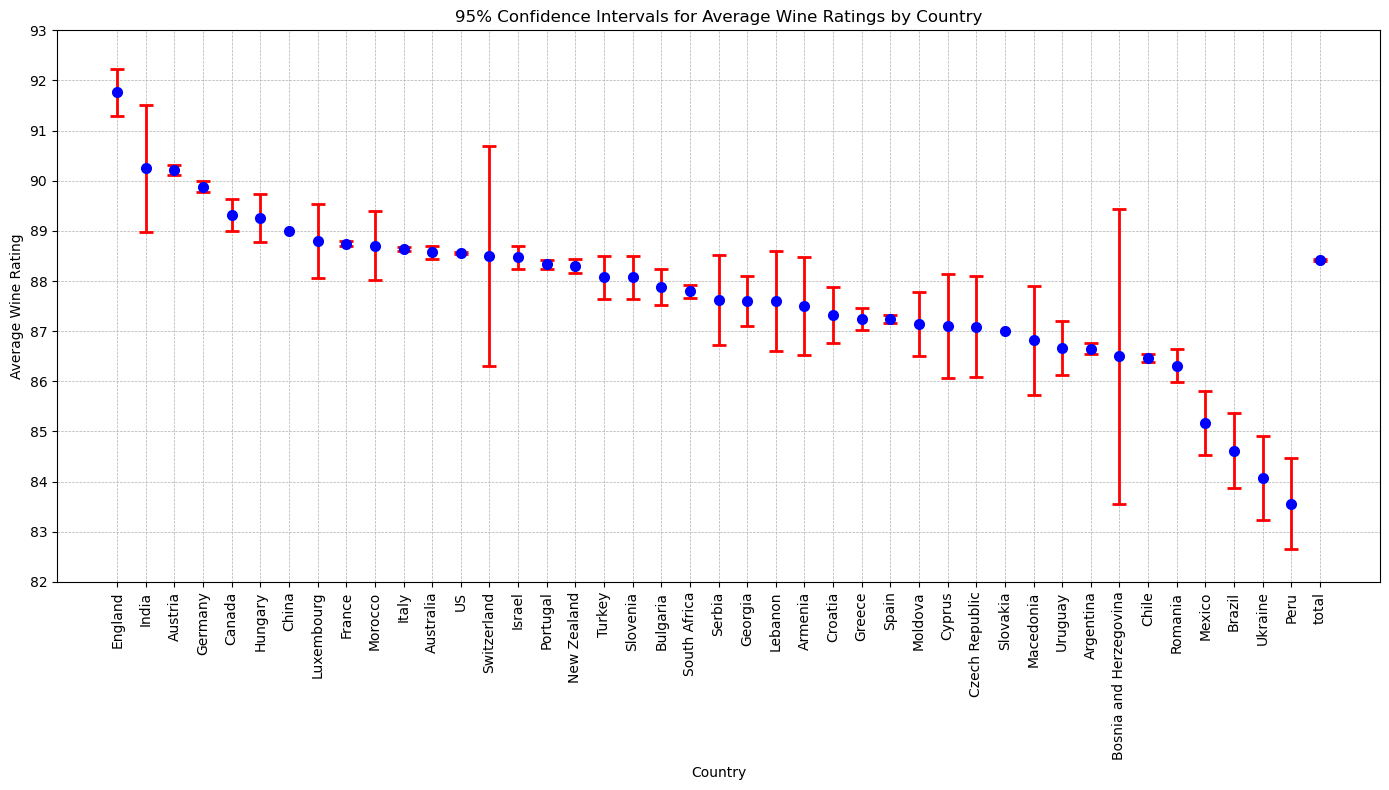

,Country,Mean,Lower CI,Upper CI
25,England,91.762712,91.292833,92.232591
32,India,90.250000,88.980338,91.519662
9,Austria,90.219637,90.121899,90.317375
5,Germany,89.878011,89.766908,89.989114
17,Canada,89.312500,88.990992,89.634008
13,Hungary,89.265625,88.786123,89.745127
41,China,89.000000,NaN,NaN
21,Luxembourg,88.800000,88.066649,89.533351
4,France,88.748127,88.701028,88.795226
30,Morocco,88.708333,88.015591,89.401076


In [51]:
# Calculate mean and standard error
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['points'])-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval}')


# Calculate mean and confidence interval for each country
countries = df['country'].unique()
confidence_intervals = []

for country in countries:
    country_data = df[df['country'] == country]['points']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df = pd.DataFrame(confidence_intervals, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df = confidence_df.sort_values(by='Mean', ascending=False)
#confidence_df = confidence_df.append('total', mean_points, confidence_interval[0], confidence_interval[1])

general_row = {'Country': 'total', 'Mean': mean_points, 'Lower CI': confidence_interval[0], 'Upper CI': confidence_interval[1]}
confidence_df.loc[len(confidence_df)] = general_row


# Plotting the confidence intervals
plt.figure(figsize=(14, 8))
plt.errorbar(confidence_df['Country'], confidence_df['Mean'], 
             yerr=[confidence_df['Mean'] - confidence_df['Lower CI'], confidence_df['Upper CI'] - confidence_df['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average Wine Rating')
plt.title('95% Confidence Intervals for Average Wine Ratings by Country')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.yticks(np.arange(82, 94, 1))

plt.show()

confidence_df


### Wine Price Confidence Intervals By Country

Dataset size: 111538
95% Confidence Interval for the Mean Price of Wines: (35.37896175353649, 35.87325722116272)


c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


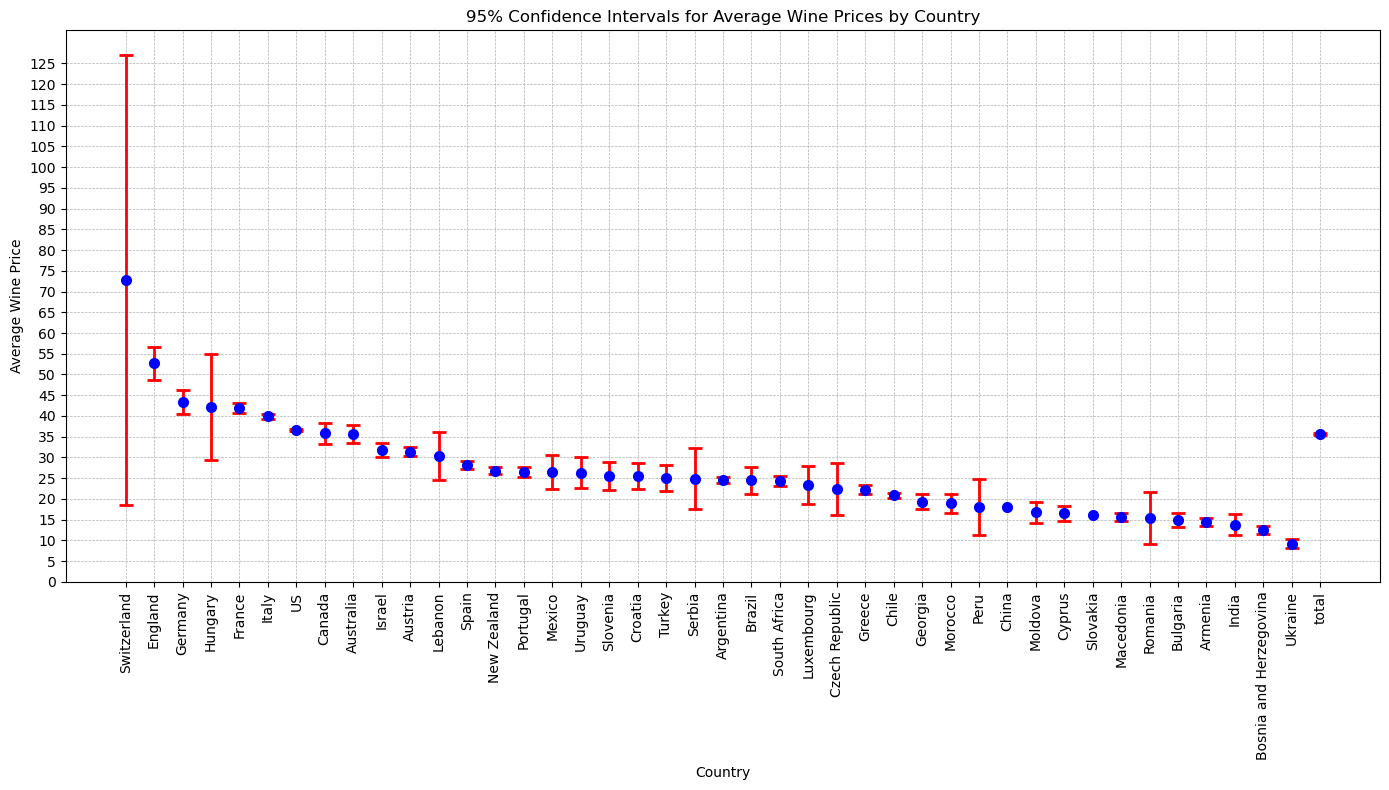

,Country,Mean,Lower CI,Upper CI
36,Switzerland,72.833333,18.634235,127.032431
25,England,52.677966,48.745903,56.610029
5,Germany,43.460789,40.569298,46.352280
13,Hungary,42.234375,29.486849,54.981901
4,France,41.994105,40.818506,43.169705
3,Italy,39.928286,39.319862,40.536710
1,US,36.697520,36.456835,36.938205
17,Canada,35.776786,33.184430,38.369142
8,Australia,35.686491,33.576358,37.796625
12,Israel,31.770419,30.030473,33.510366


In [58]:
# Calculate mean and standard error for the entire dataset for 'price'
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval for the entire dataset for 'price'
confidence_interval_price = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval_price}')

# Calculate mean and confidence interval for each country for 'price'
countries = df['country'].unique()
confidence_intervals_price = []

for country in countries:
    country_data = df[df['country'] == country]['price']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_price.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_price = pd.DataFrame(confidence_intervals_price, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_price = confidence_df_price.sort_values(by='Mean', ascending=False)

# Append the total statistics to the country data for 'price'
general_row_price = {'Country': 'total', 'Mean': mean_price, 'Lower CI': confidence_interval_price[0], 'Upper CI': confidence_interval_price[1]}
confidence_df_price.loc[len(confidence_df_price)] = general_row_price

# Plotting the confidence intervals for 'price'
plt.figure(figsize=(14, 8))
plt.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average Wine Price')
plt.title('95% Confidence Intervals for Average Wine Prices by Country')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.yticks(np.arange(0, 130, 5))  # Adjust this range based on your 'price' data

plt.show()

confidence_df_price


### Comparison

C:\Users\nicol\AppData\Local\Temp\ipykernel_34224\177023978.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(confidence_df['Country'], rotation=90)
C:\Users\nicol\AppData\Local\Temp\ipykernel_34224\177023978.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)


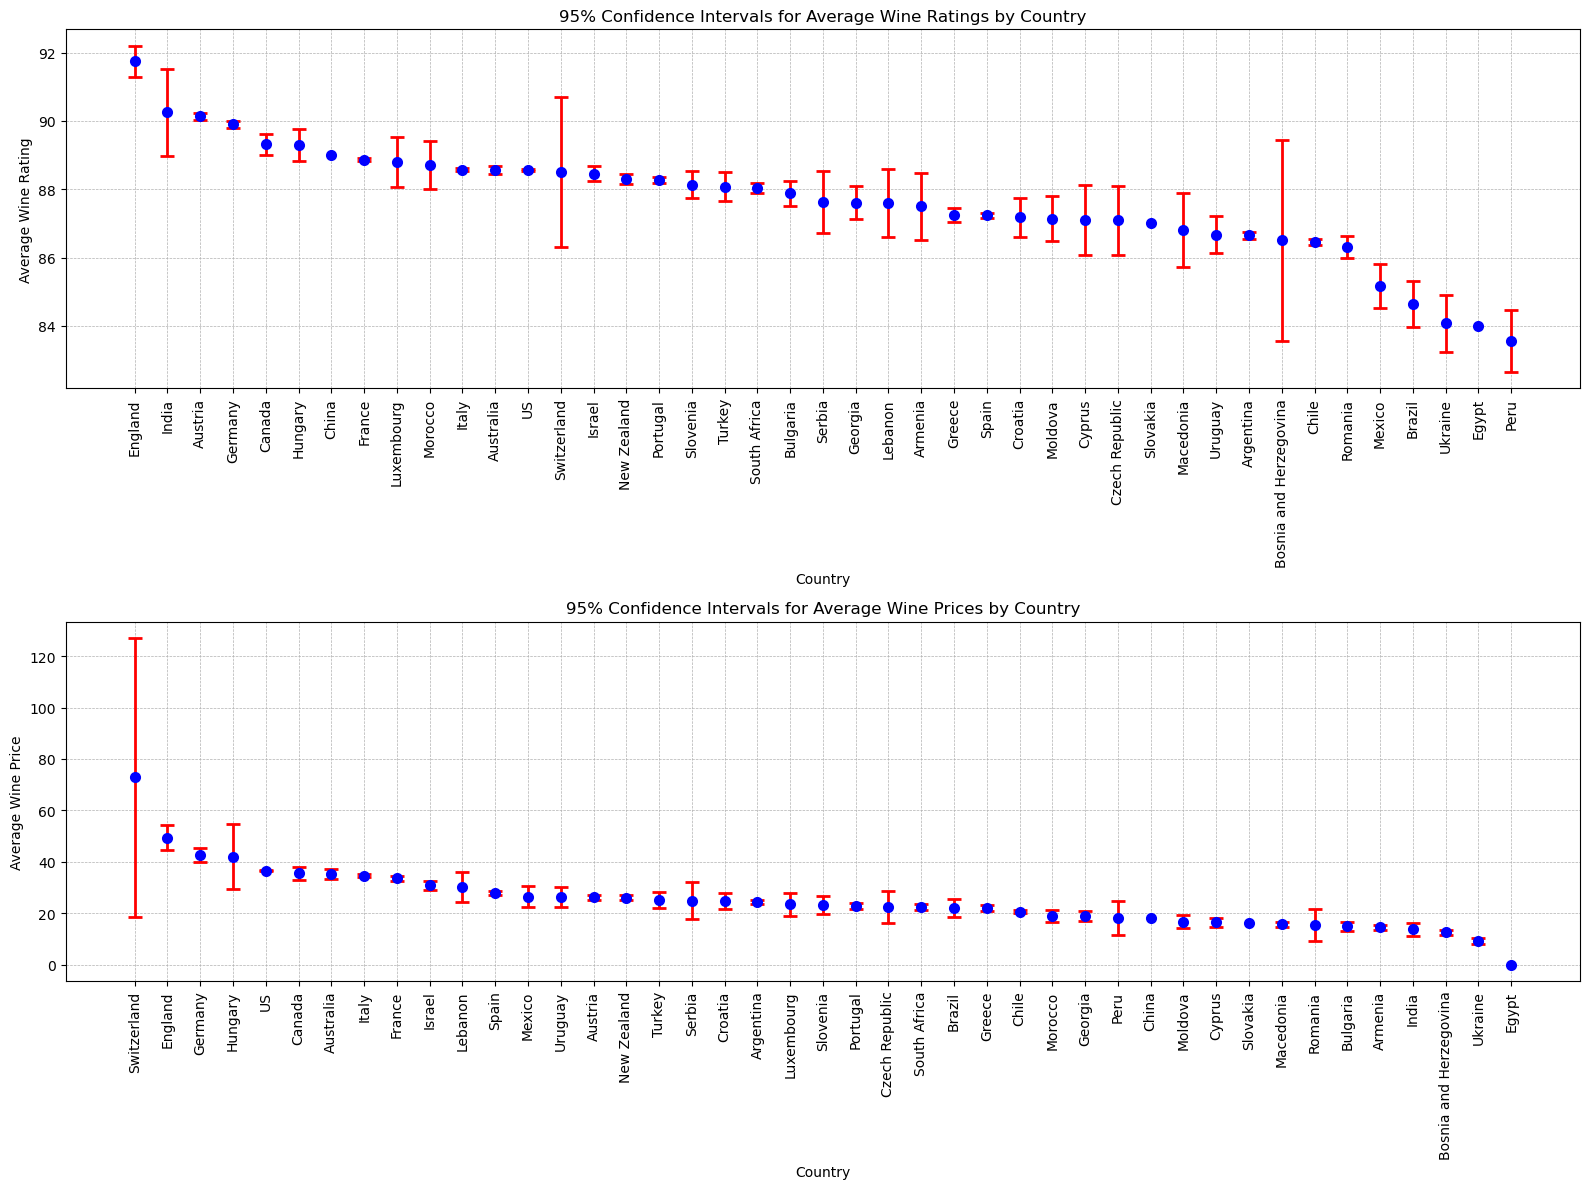

In [ ]:
# Plotting the confidence intervals for both wine ratings and prices side by side

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot for wine ratings
ax1.errorbar(confidence_df['Country'], confidence_df['Mean'], 
             yerr=[confidence_df['Mean'] - confidence_df['Lower CI'], confidence_df['Upper CI'] - confidence_df['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax1.set_xticklabels(confidence_df['Country'], rotation=90)
ax1.set_xlabel('Country')
ax1.set_ylabel('Average Wine Rating')
ax1.set_title('95% Confidence Intervals for Average Wine Ratings by Country')
ax1.grid(True, linestyle='--', linewidth=0.5)

# Plot for wine prices
ax2.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)
ax2.set_xlabel('Country')
ax2.set_ylabel('Average Wine Price')
ax2.set_title('95% Confidence Intervals for Average Wine Prices by Country')
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### 2 plot same country

Dataset size: 111538
95% Confidence Interval for the Mean Points of Wines: (88.39561673460544, 88.43199358654071)


c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


95% Confidence Interval for the Mean Price of Wines: (35.37896175353649, 35.87325722116272)


c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\nicol\AppData\Local\Temp\ipykernel_30280\3250011519.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(confidence_df_points['Country'], rotation=90)
C:\Users\nicol\AppData\Local\Temp\ipykernel_30280\3250011519.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)


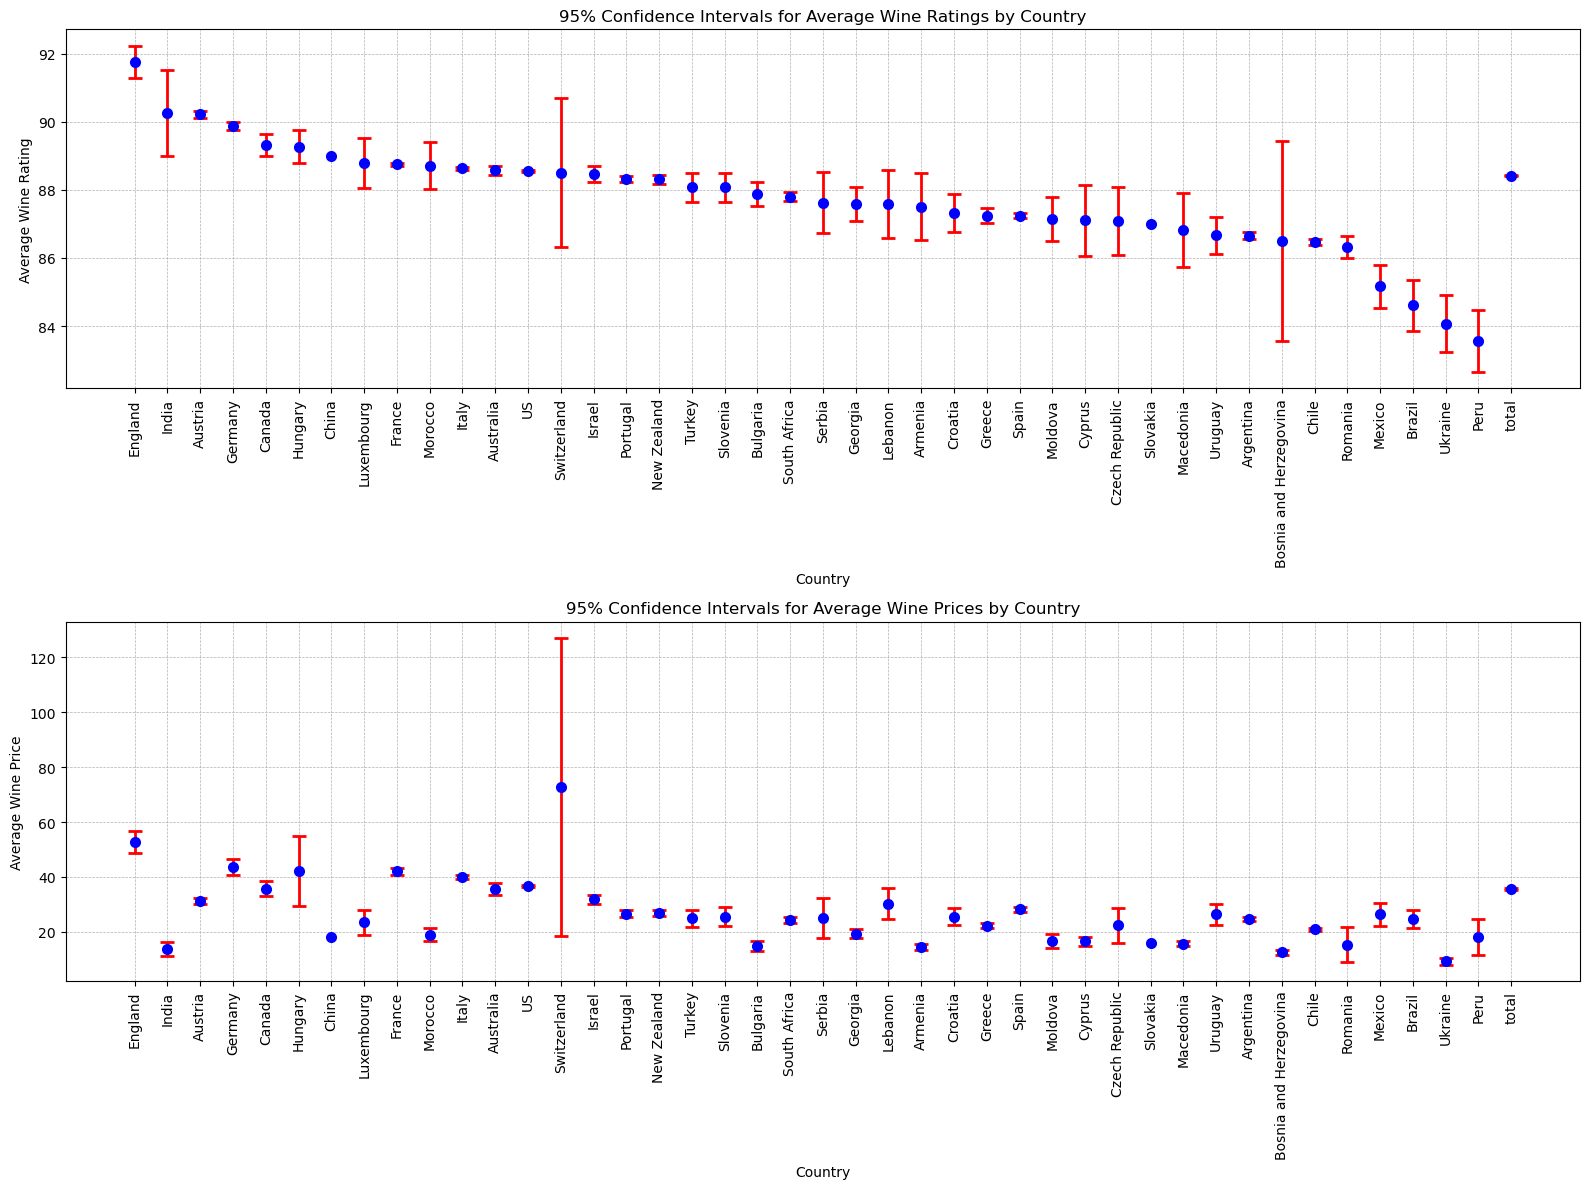

,Country,Mean,Lower CI,Upper CI
0,England,52.677966,48.745903,56.610029
1,India,13.750000,11.217439,16.282561
2,Austria,31.336751,30.237183,32.436319
3,Germany,43.460789,40.569298,46.352280
4,Canada,35.776786,33.184430,38.369142
5,Hungary,42.234375,29.486849,54.981901
6,China,18.000000,NaN,NaN
7,Luxembourg,23.400000,18.862355,27.937645
8,France,41.994105,40.818506,43.169705
9,Morocco,18.958333,16.615154,21.301513


In [59]:
# Calculate mean and standard error for the entire dataset for 'points'
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval for the entire dataset for 'points'
confidence_interval_points = stats.t.interval(0.95, len(df['points'].dropna())-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval_points}')

# Calculate mean and confidence interval for each country for 'points'
countries = df['country'].unique()
confidence_intervals_points = []

for country in countries:
    country_data = df[df['country'] == country]['points']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_points.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_points = pd.DataFrame(confidence_intervals_points, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_points = confidence_df_points.sort_values(by='Mean', ascending=False)

# Append the total statistics to the country data for 'points'
general_row_points = {'Country': 'total', 'Mean': mean_points, 'Lower CI': confidence_interval_points[0], 'Upper CI': confidence_interval_points[1]}
confidence_df_points.loc[len(confidence_df_points)] = general_row_points

# Calculate mean and standard error for the entire dataset for 'price'
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval for the entire dataset for 'price'
confidence_interval_price = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval_price}')

# Calculate mean and confidence interval for each country for 'price'
confidence_intervals_price = []

for country in countries:
    country_data = df[df['country'] == country]['price']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_price.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_price = pd.DataFrame(confidence_intervals_price, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])

# Align the order of countries in 'confidence_df_price' to match 'confidence_df_points'
confidence_df_price = confidence_df_price.set_index('Country').reindex(confidence_df_points['Country']).reset_index()

# Append the total statistics to the country data for 'price'
general_row_price = {'Country': 'total', 'Mean': mean_price, 'Lower CI': confidence_interval_price[0], 'Upper CI': confidence_interval_price[1]}
confidence_df_price.loc[len(confidence_df_price)] = general_row_price

# Plotting the confidence intervals for both wine ratings and prices side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot for wine ratings
ax1.errorbar(confidence_df_points['Country'], confidence_df_points['Mean'], 
             yerr=[confidence_df_points['Mean'] - confidence_df_points['Lower CI'], confidence_df_points['Upper CI'] - confidence_df_points['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax1.set_xticklabels(confidence_df_points['Country'], rotation=90)
ax1.set_xlabel('Country')
ax1.set_ylabel('Average Wine Rating')
ax1.set_title('95% Confidence Intervals for Average Wine Ratings by Country')
ax1.grid(True, linestyle='--', linewidth=0.5)

# Plot for wine prices
ax2.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)
ax2.set_xlabel('Country')
ax2.set_ylabel('Average Wine Price')
ax2.set_title('95% Confidence Intervals for Average Wine Prices by Country')
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

### 2 plot with size

95% Confidence Interval for the Mean Points of Wines: (88.39561673460544, 88.43199358654071)


c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


95% Confidence Interval for the Mean Price of Wines: (35.37896175353649, 35.87325722116272)


c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\nicol\AppData\Local\Temp\ipykernel_30280\1293572167.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(confidence_df_points['Country'], rotation=90)
C:\Users\nicol\AppData\Local\Temp\ipykernel_30280\1293572167.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)


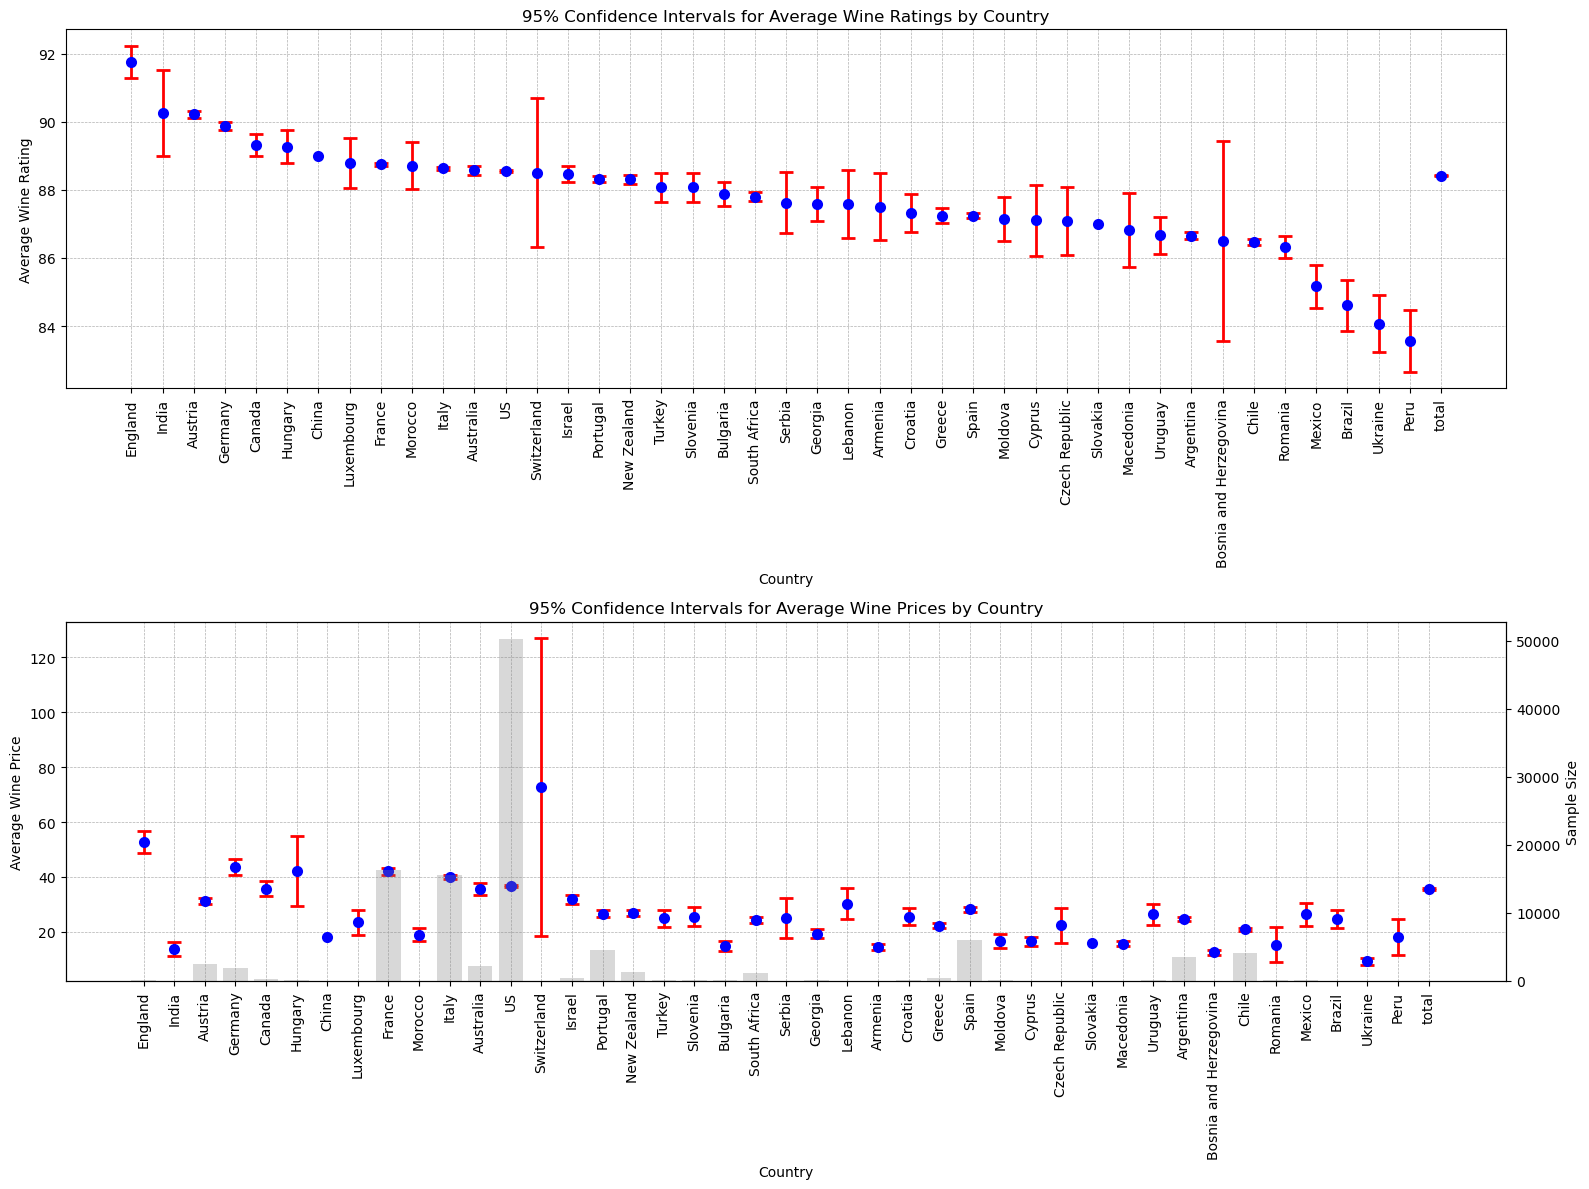

In [64]:
# Calculate mean and standard error for the entire dataset for 'points'
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval for the entire dataset for 'points'
confidence_interval_points = stats.t.interval(0.95, len(df['points'].dropna())-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval_points}')

# Calculate mean and confidence interval for each country for 'points'
countries = df['country'].unique()
confidence_intervals_points = []

for country in countries:
    country_data = df[df['country'] == country]['points']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_points.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_points = pd.DataFrame(confidence_intervals_points, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_points = confidence_df_points.sort_values(by='Mean', ascending=False)

# Append the total statistics to the country data for 'points'
general_row_points = {'Country': 'total', 'Mean': mean_points, 'Lower CI': confidence_interval_points[0], 'Upper CI': confidence_interval_points[1]}
confidence_df_points.loc[len(confidence_df_points)] = general_row_points

# Calculate mean and standard error for the entire dataset for 'price'
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval for the entire dataset for 'price'
confidence_interval_price = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval_price}')

# Calculate mean and confidence interval for each country for 'price'
confidence_intervals_price = []

for country in countries:
    country_data = df[df['country'] == country]['price']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_price.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_price = pd.DataFrame(confidence_intervals_price, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])

# Align the order of countries in 'confidence_df_price' to match 'confidence_df_points'
confidence_df_price = confidence_df_price.set_index('Country').reindex(confidence_df_points['Country']).reset_index()

# Append the total statistics to the country data for 'price'
general_row_price = {'Country': 'total', 'Mean': mean_price, 'Lower CI': confidence_interval_price[0], 'Upper CI': confidence_interval_price[1]}
confidence_df_price.loc[len(confidence_df_price)] = general_row_price

# Calculate the sample size for each country
sample_sizes = df['country'].value_counts().reindex(confidence_df_price['Country']).fillna(0)

# Plotting the confidence intervals for both wine ratings and prices side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot for wine ratings
ax1.errorbar(confidence_df_points['Country'], confidence_df_points['Mean'], 
             yerr=[confidence_df_points['Mean'] - confidence_df_points['Lower CI'], confidence_df_points['Upper CI'] - confidence_df_points['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax1.set_xticklabels(confidence_df_points['Country'], rotation=90)
ax1.set_xlabel('Country')
ax1.set_ylabel('Average Wine Rating')
ax1.set_title('95% Confidence Intervals for Average Wine Ratings by Country')
ax1.grid(True, linestyle='--', linewidth=0.5)

# Plot for wine prices with histogram for sample sizes
ax2.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)
ax2.set_xlabel('Country')
ax2.set_ylabel('Average Wine Price')
ax2.set_title('95% Confidence Intervals for Average Wine Prices by Country')
ax2.grid(True, linestyle='--', linewidth=0.5)

# Secondary y-axis for sample sizes histogram
ax3 = ax2.twinx()
ax3.bar(confidence_df_price['Country'], sample_sizes, alpha=0.3, color='grey')
ax3.set_ylabel('Sample Size')

plt.tight_layout()
plt.show()


### 2 plot with size log

Dataset size: 111538
95% Confidence Interval for the Mean Points of Wines: (88.39561673460544, 88.43199358654071)


c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


95% Confidence Interval for the Mean Price of Wines: (35.37896175353649, 35.87325722116272)


c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\nicol\AppData\Local\Temp\ipykernel_30280\3370092893.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(confidence_df_points['Country'], rotation=90)
C:\Users\nicol\AppData\Local\Temp\ipykernel_30280\3370092893.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)


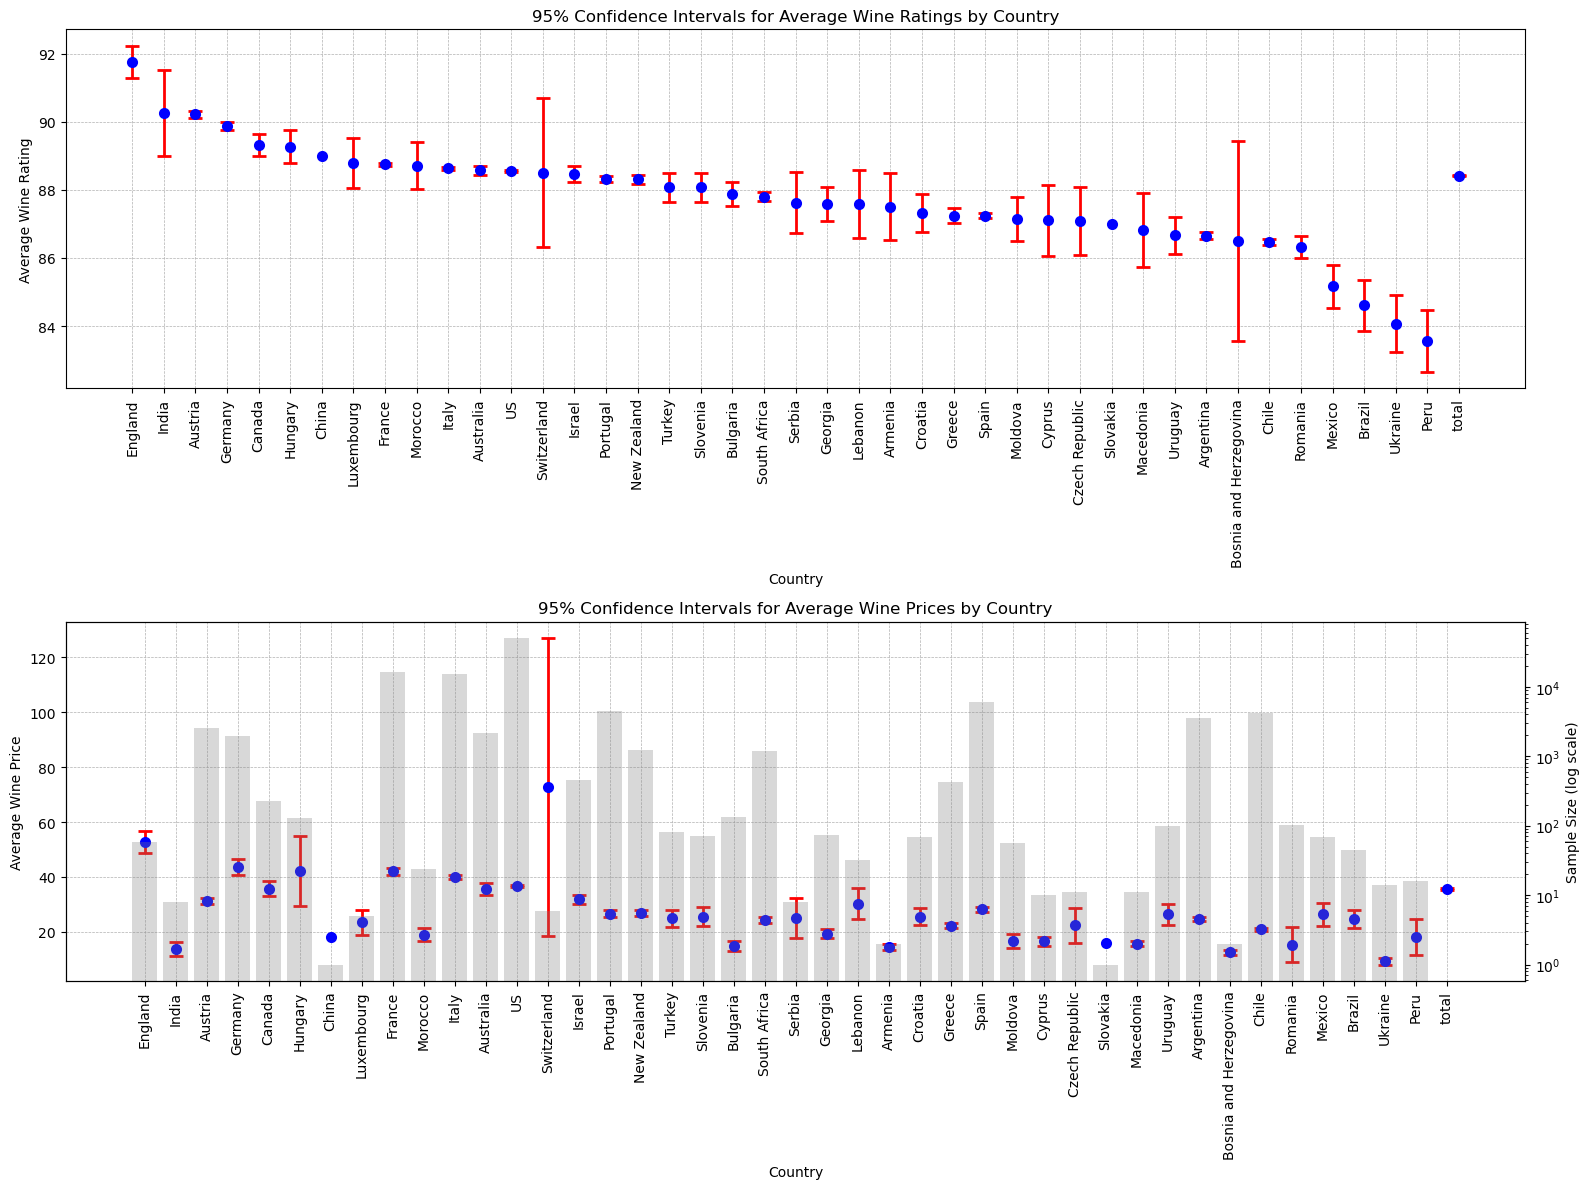

In [63]:
print(f"Dataset size: {len(df)}")

# Calculate mean and standard error for the entire dataset for 'points'
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval for the entire dataset for 'points'
confidence_interval_points = stats.t.interval(0.95, len(df['points'].dropna())-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval_points}')

# Calculate mean and confidence interval for each country for 'points'
countries = df['country'].unique()
confidence_intervals_points = []

for country in countries:
    country_data = df[df['country'] == country]['points']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_points.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_points = pd.DataFrame(confidence_intervals_points, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])
confidence_df_points = confidence_df_points.sort_values(by='Mean', ascending=False)

# Append the total statistics to the country data for 'points'
general_row_points = {'Country': 'total', 'Mean': mean_points, 'Lower CI': confidence_interval_points[0], 'Upper CI': confidence_interval_points[1]}
confidence_df_points.loc[len(confidence_df_points)] = general_row_points

# Calculate mean and standard error for the entire dataset for 'price'
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval for the entire dataset for 'price'
confidence_interval_price = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval_price}')

# Calculate mean and confidence interval for each country for 'price'
confidence_intervals_price = []

for country in countries:
    country_data = df[df['country'] == country]['price']
    mean = np.mean(country_data)
    confidence = stats.norm.interval(0.95, loc=mean, scale=stats.sem(country_data))
    confidence_intervals_price.append((country, mean, confidence[0], confidence[1]))

# Create a DataFrame for better visualization
confidence_df_price = pd.DataFrame(confidence_intervals_price, columns=['Country', 'Mean', 'Lower CI', 'Upper CI'])

# Align the order of countries in 'confidence_df_price' to match 'confidence_df_points'
confidence_df_price = confidence_df_price.set_index('Country').reindex(confidence_df_points['Country']).reset_index()

# Append the total statistics to the country data for 'price'
general_row_price = {'Country': 'total', 'Mean': mean_price, 'Lower CI': confidence_interval_price[0], 'Upper CI': confidence_interval_price[1]}
confidence_df_price.loc[len(confidence_df_price)] = general_row_price

# Calculate the sample size for each country
sample_sizes = df['country'].value_counts().reindex(confidence_df_price['Country']).fillna(0)

# Plotting the confidence intervals for both wine ratings and prices side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot for wine ratings
ax1.errorbar(confidence_df_points['Country'], confidence_df_points['Mean'], 
             yerr=[confidence_df_points['Mean'] - confidence_df_points['Lower CI'], confidence_df_points['Upper CI'] - confidence_df_points['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax1.set_xticklabels(confidence_df_points['Country'], rotation=90)
ax1.set_xlabel('Country')
ax1.set_ylabel('Average Wine Rating')
ax1.set_title('95% Confidence Intervals for Average Wine Ratings by Country')
ax1.grid(True, linestyle='--', linewidth=0.5)

# Plot for wine prices with histogram for sample sizes
ax2.errorbar(confidence_df_price['Country'], confidence_df_price['Mean'], 
             yerr=[confidence_df_price['Mean'] - confidence_df_price['Lower CI'], confidence_df_price['Upper CI'] - confidence_df_price['Mean']], 
             fmt='o', ecolor='r', capsize=5, elinewidth=2, markeredgewidth=2, color='blue')
ax2.set_xticklabels(confidence_df_price['Country'], rotation=90)
ax2.set_xlabel('Country')
ax2.set_ylabel('Average Wine Price')
ax2.set_title('95% Confidence Intervals for Average Wine Prices by Country')
ax2.grid(True, linestyle='--', linewidth=0.5)

# Secondary y-axis for sample sizes histogram with log scale
ax3 = ax2.twinx()
ax3.bar(confidence_df_price['Country'], sample_sizes, alpha=0.3, color='grey')
ax3.set_ylabel('Sample Size (log scale)')
ax3.set_yscale('log')

plt.tight_layout()
plt.show()

95% Confidence Interval for the Mean Points of Wines: (88.39561673460544, 88.43199358654071)


c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicol\anaconda3\envs\dc24\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


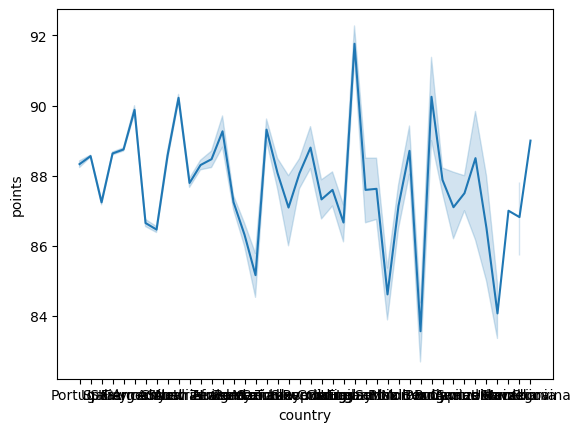

In [ ]:
# Calculate mean and standard error
mean_points = df['points'].mean()
sem_points = stats.sem(df['points'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['points'])-1, loc=mean_points, scale=sem_points)
print(f'95% Confidence Interval for the Mean Points of Wines: {confidence_interval}')

mean = mean_points
lower_ci, upper_ci = confidence_interval
yerr = [[mean - lower_ci], [upper_ci - mean]]


# line plot with 95% confidence interval
sns.lineplot(data=df, x="country", y="points", errorbar="ci")
plt.show()

NameError: name 'mean_points' is not defined

In [ ]:
# Calculate mean and standard error
mean_price = df['price'].mean()
sem_price = stats.sem(df['price'].dropna())

# Calculate the confidence interval
confidence_interval = stats.t.interval(0.95, len(df['price'].dropna())-1, loc=mean_price, scale=sem_price)
print(f'95% Confidence Interval for the Mean Price of Wines: {confidence_interval}')

95% Confidence Interval for the Mean Price of Wines: (32.89309808840795, 33.36396095082931)


##  hnpp

# Linear Regression and correlation analysis

## Scatterplots and Correlation

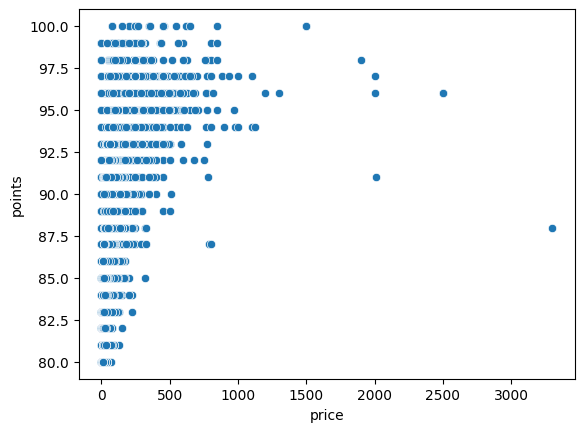

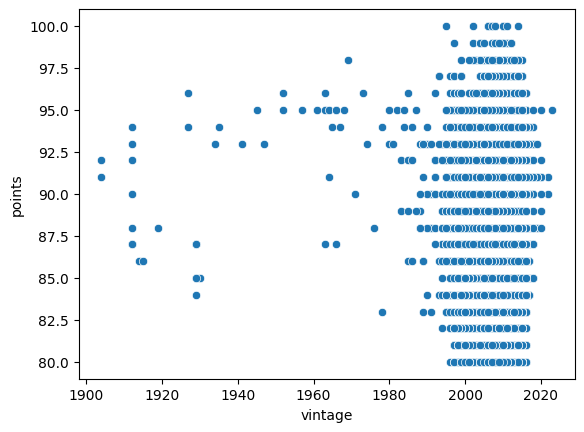

In [ ]:
for i in ['price', 'vintage']:
    sns.scatterplot(data=df, x=i, y="points")
    plt.show()


<Figure size 1200x800 with 0 Axes>

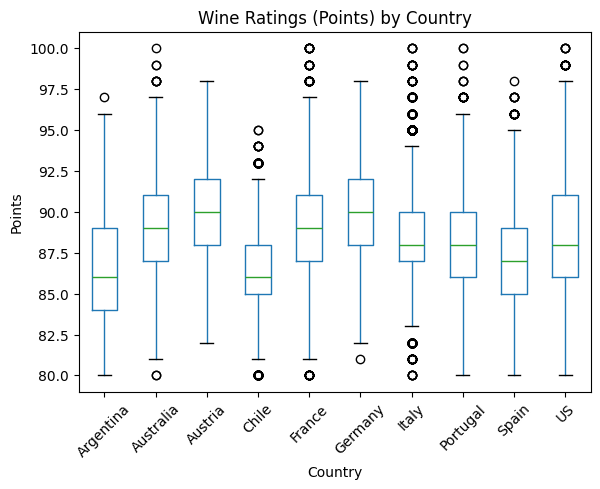

country
US                        50457
France                    20353
Italy                     17940
Spain                      6116
Portugal                   5256
Chile                      4184
Argentina                  3544
Austria                    3034
Australia                  2197
Germany                    1992
South Africa               1301
New Zealand                1278
Israel                      466
Greece                      432
Canada                      226
Bulgaria                    132
Hungary                     129
Romania                     102
Uruguay                      98
Turkey                       81
Slovenia                     77
Georgia                      76
Croatia                      70
Mexico                       68
England                      63
Unknown                      59
Moldova                      56
Brazil                       49
Lebanon                      32
Morocco                      24
Peru                         16


In [ ]:
# Select top 10 countries by the number of wine reviews
top_countries = df['country'].value_counts().head(10).index
top_countries_data = df[df['country'].isin(top_countries)]

# Box plot for points by country
plt.figure(figsize=(12, 8))
top_countries_data.boxplot(column='points', by='country', grid=False)
plt.title('Wine Ratings (Points) by Country')
plt.suptitle('')
plt.xlabel('Country')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.show()
print((df['country'].value_counts()))

<Axes: >

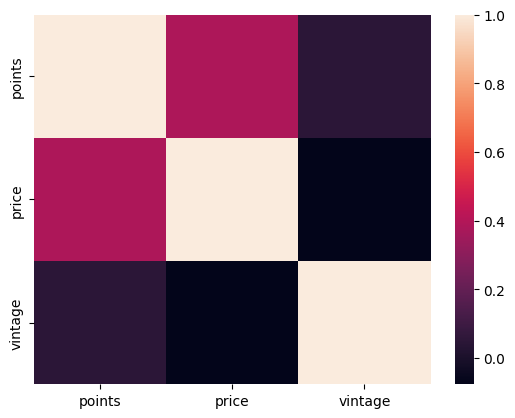

In [ ]:
s = df.select_dtypes(include="number").corr()
sns.heatmap(s)

# Conclusions